In [1]:
# Connect WRDS
import wrds

db = wrds.Connection(wrds_username='yanqinglin')

Loading library list...
Done


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import fsolve
from pandas_datareader import data as pdr
import datetime
import wrds
import warnings
from scipy.optimize import minimize
from scipy.optimize import newton
warnings.filterwarnings('ignore')

Retrieving Barrick Gold's debt data...
=== Quarterly Debt Data (debt_quarterly) ===
             gvkey   dlttq  dlcq            Lt
datadate                                      
2023-12-31  002055  5180.0  43.0  2633000000.0
2024-03-31  002055  4713.0  12.0  2368500000.0
2024-06-30  002055  4713.0  11.0  2367500000.0
2024-09-30  002055  4712.0  13.0  2369000000.0
2024-12-31  002055  5172.0  84.0  2670000000.0

=== Daily Interpolated Debt Data (daily_debt) ===
                           Lt
date                         
2023-12-31       2633000000.0
2024-01-01  2630093406.593407
2024-01-02  2627186813.186813
2024-01-03   2624280219.78022
2024-01-04  2621373626.373626
...                       ...
2024-12-27  2656913043.478261
2024-12-28  2660184782.608696
2024-12-29   2663456521.73913
2024-12-30  2666728260.869565
2024-12-31       2670000000.0

[367 rows x 1 columns]


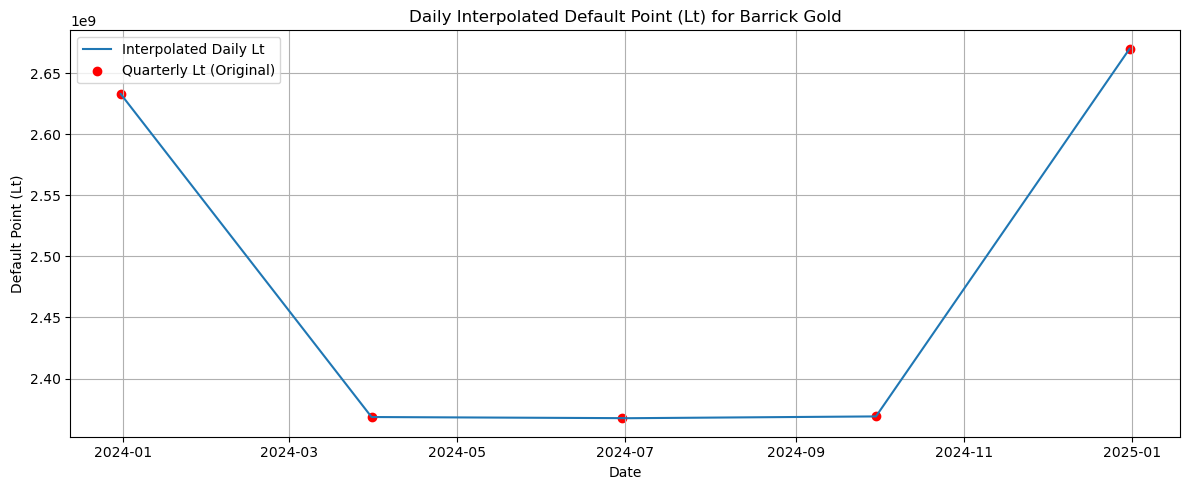

In [3]:
# Question 1
# Retrieve debt data from Compustat for Barrick Gold
print("Retrieving Barrick Gold's debt data...")
query_debt = """
SELECT datadate, gvkey, dlttq, dlcq
FROM comp.fundq
WHERE gvkey = '002055' 
  AND datadate BETWEEN '2023-10-01' AND '2024-12-31'
ORDER BY datadate
"""
debt_quarterly = db.raw_sql(query_debt)

# Convert date column to datetime format
debt_quarterly['datadate'] = pd.to_datetime(debt_quarterly['datadate'])

# Calculate default point Lt as current liabilities + 50% of long-term debt
# dlcq and dlttq are in million USD
debt_quarterly['Lt'] = (debt_quarterly['dlcq'] + 0.5 * debt_quarterly['dlttq']) * 1000000

# Set the date as the index
debt_quarterly.set_index('datadate', inplace=True)

# Create a daily date range covering the period of the available data
daily_dates = pd.date_range(start=debt_quarterly.index.min(), end=debt_quarterly.index.max())
daily_debt = pd.DataFrame(index=daily_dates)

# Join and interpolate quarterly data to get daily values
daily_debt = daily_debt.join(debt_quarterly[['Lt']])
daily_debt = daily_debt.interpolate(method='linear')
daily_debt.index.name = "date"

# Display the original quarterly debt data
print("=== Quarterly Debt Data (debt_quarterly) ===")
print(debt_quarterly)

# Display the interpolated daily debt data
print("\n=== Daily Interpolated Debt Data (daily_debt) ===")
print(daily_debt)

# Plot the interpolated default point over time
plt.figure(figsize=(12, 5))
plt.plot(daily_debt.index, daily_debt['Lt'], label='Interpolated Daily Lt')
plt.scatter(debt_quarterly.index, debt_quarterly['Lt'], color='red', label='Quarterly Lt (Original)')
plt.title('Daily Interpolated Default Point (Lt) for Barrick Gold')
plt.xlabel('Date')
plt.ylabel('Default Point (Lt)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Retrieving Barrick Gold's stock price and shares outstanding...
=== Daily Market Capitalization ===
                    market_cap
date                          
2024-01-02       31397280000.0
2024-01-03  30431479999.999996
2024-01-04  30466600000.000004
2024-01-05  30712439999.999996
2024-01-08  31063640000.000004
...                        ...
2024-12-24       27461849790.0
2024-12-26       27514291260.0
2024-12-27       27409408320.0
2024-12-30       27024837540.0
2024-12-31       27094759500.0

[252 rows x 1 columns]


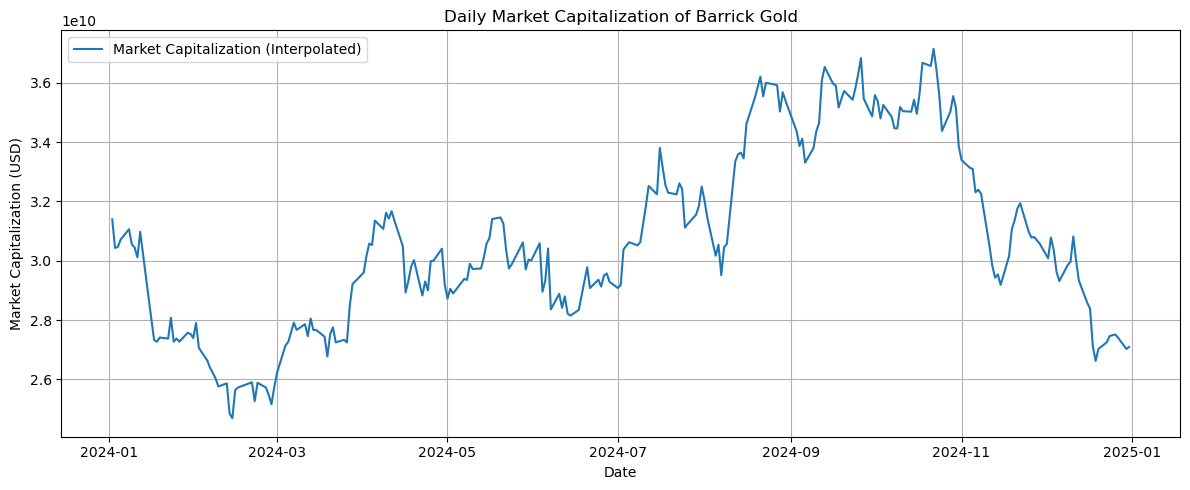

In [4]:
# Question 2
# Get stock price and shares outstanding from CRSP
print("Retrieving Barrick Gold's stock price and shares outstanding...")
query_stock = """
SELECT date, prc, shrout
FROM crsp.dsf
WHERE permno = 71298
  AND date BETWEEN '2023-12-31' AND '2024-12-31'
ORDER BY date
"""
stock_data = db.raw_sql(query_stock)

# Convert date column and clean up
stock_data['date'] = pd.to_datetime(stock_data['date'])
stock_data['prc'] = stock_data['prc'].abs()  # Ensure positive prices
stock_data['shrout'] = stock_data['shrout'] * 1000  # Convert from thousands to shares
stock_data['market_cap'] = stock_data['prc'] * stock_data['shrout']
stock_data.set_index('date', inplace=True)
stock_data = stock_data.sort_index()  # Ensure chronological order

# Keep only market cap
stock_data = stock_data[['market_cap']]

# Print the daily market capitalization after interpolation
print("=== Daily Market Capitalization ===")
print(stock_data)

# Plot the daily market capitalization time series
plt.figure(figsize=(12, 5))
plt.plot(stock_data.index, stock_data['market_cap'], label='Market Capitalization (Interpolated)')
plt.title('Daily Market Capitalization of Barrick Gold')
plt.xlabel('Date')
plt.ylabel('Market Capitalization (USD)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [5]:
# Question 3
# Retrieve risk-free rate (1-year zero-coupon yield from St. Louis Fed)
print("Fetching 1-year zero-coupon Treasury yield...")

start_date = debt_quarterly.index.min()
end_date = debt_quarterly.index.max()

risk_free_data = pdr.get_data_fred('THREEFY1', start=start_date, end=end_date)
risk_free_data = risk_free_data / 100  # Convert from percentage to decimal
risk_free_data.index = pd.to_datetime(risk_free_data.index)
risk_free_data = risk_free_data.dropna()

print("Successfully retrieved risk-free rate data:")
print(risk_free_data)

Fetching 1-year zero-coupon Treasury yield...
Successfully retrieved risk-free rate data:
            THREEFY1
DATE                
2024-01-02  0.047805
2024-01-03  0.047802
2024-01-04  0.048062
2024-01-05  0.048169
2024-01-08  0.047959
...              ...
2024-12-24  0.043222
2024-12-26  0.043109
2024-12-27  0.043011
2024-12-30  0.042641
2024-12-31  0.042575

[250 rows x 1 columns]


In [6]:
def merton_system(E, L, r, T, sigma_E, tol=1e-8, maxiter=100):
    E = float(E)
    L = float(L)
    r = float(r)
    sigma_E = float(sigma_E)
    sigma_V = sigma_E

    for i in range(maxiter):
        # (1) Given current asset volatility sigma_V, solve for asset value V
        def equity_resid(V):
            d1 = (np.log(V / L) + (r + 0.5 * sigma_V**2) * T) / (sigma_V * np.sqrt(T))
            d2 = d1 - sigma_V * np.sqrt(T)
            return V * norm.cdf(d1) - L * np.exp(-r * T) * norm.cdf(d2) - E

        # initial guess: equity + PV of liabilities
        V0 = E + L * np.exp(-r * T)
        V = newton(equity_resid, V0)

        # (2) Update asset volatility from equity-vol mapping
        d1 = (np.log(V / L) + (r + 0.5 * sigma_V**2) * T) / (sigma_V * np.sqrt(T))
        sigma_V_new = sigma_E * E / (V * norm.cdf(d1))

        # (3) Check for convergence in sigma_V
        if abs(sigma_V_new - sigma_V) < tol:
            sigma_V = sigma_V_new
            break
        sigma_V = sigma_V_new

    return V, sigma_V

# ——— Data merging & cleaning ———
# 1) Ensure datetime index and sort chronologically
daily_debt     = daily_debt.sort_index()
stock_data     = stock_data.sort_index()
risk_free_data = risk_free_data.sort_index()

# 2) Concatenate into a single DataFrame
data = pd.concat([
    daily_debt[['Lt']],
    stock_data[['market_cap']],
    risk_free_data.rename(columns={'THREEFY1': 'risk_free_rate'})
], axis=1)

# 3) Drop rows with missing values, starting from the first valid market_cap
data = data.loc[data['market_cap'].first_valid_index():].dropna()

print("=== Combined Daily Data ===")
print(data.head(), "\n", data.tail())

# ——— Compute σ_E and extract 2024‑12‑31 values ———
# 4) Compute daily log‑returns of market cap and take the standard deviation
rets      = np.log(data['market_cap']).diff().dropna()
sigma_E = rets.std()                   # equity volatility (daily)

# 5) Extract end‑of‑2024 scalars
E_2024 = data.loc['2024-12-31', 'market_cap'].item()
L_2024 = data.loc['2024-12-31', 'Lt'].item()
r_2024 = data.loc['2024-12-31', 'risk_free_rate'].item()

# ——— Run Merton model to get V and σ_V ———
V_2024, sigma_V_2024 = merton_system(
    E=E_2024,
    L=L_2024,
    r=r_2024,
    T=1.0,
    sigma_E=sigma_E
)

print(f"Estimated asset value on 2024-12-31: {V_2024:,.2f} USD")
print(f"Estimated daily asset volatility on 2024-12-31: {sigma_V_2024:.2%}")
print(f"Estimated annualized asset volatility on 2024-12-31: {sigma_V_2024 * np.sqrt(252):.2%}")

=== Combined Daily Data ===
                           Lt          market_cap  risk_free_rate
2024-01-02  2627186813.186813       31397280000.0        0.047805
2024-01-03   2624280219.78022  30431479999.999996        0.047802
2024-01-04  2621373626.373626  30466600000.000004        0.048062
2024-01-05  2618467032.967033  30712439999.999996        0.048169
2024-01-08  2609747252.747253  31063640000.000004        0.047959 
                            Lt     market_cap  risk_free_rate
2024-12-24  2647097826.086957  27461849790.0        0.043222
2024-12-26  2653641304.347826  27514291260.0        0.043109
2024-12-27  2656913043.478261  27409408320.0        0.043011
2024-12-30  2666728260.869565  27024837540.0        0.042641
2024-12-31       2670000000.0  27094759500.0        0.042575
Estimated asset value on 2024-12-31: 29,653,470,132.45 USD
Estimated daily asset volatility on 2024-12-31: 1.97%
Estimated annualized asset volatility on 2024-12-31: 31.28%


=== Default Frontier (Quarterly) ===
    Default Point
0    2.538316e+09
1    2.670000e+09
2    2.801684e+09
3    2.933368e+09
4    3.065053e+09
5    3.196737e+09
6    3.328421e+09
7    3.460105e+09
8    3.591789e+09
9    3.723474e+09
10   3.855158e+09
11   3.986842e+09
12   4.118526e+09
13   4.250211e+09
14   4.381895e+09
15   4.513579e+09
16   4.645263e+09
17   4.776947e+09
18   4.908632e+09
19   5.040316e+09
20   5.172000e+09


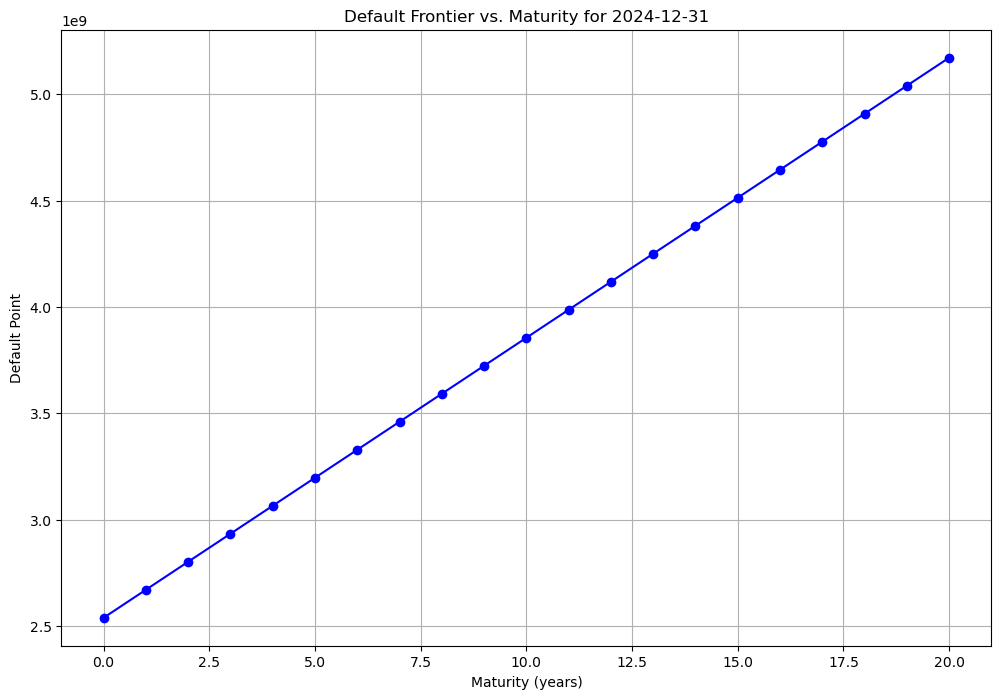

In [7]:
# Question 4
# Data Preparation
lt = debt_quarterly.Lt[-1]  
dlttq = debt_quarterly.dlttq[-1] * 1_000_000  # Convert to the correct scale (dollars)

# Calculate Default Frontier

# Create an array for maturities: from 0 to 20 years (a total of 21 values)
maturities = np.arange(0, 21)

# Calculate the default point for each maturity using vectorized operations
default_points = lt + ((maturities - 1) / (20 - 1)) * (dlttq - lt)

# Construct a DataFrame with the maturities as the index and a single column named "Default Point"
default_frontier_df = pd.DataFrame(default_points, index=maturities, columns=["Default Point"])

# Print the generated DataFrame
print("=== Default Frontier (Quarterly) ===")
print(default_frontier_df)

# Plotting
plt.figure(figsize=(12, 8))
plt.plot(default_frontier_df.index, default_frontier_df["Default Point"], marker='o', color='blue')
plt.title("Default Frontier vs. Maturity for 2024-12-31")
plt.xlabel("Maturity (years)")
plt.ylabel("Default Point")
plt.grid(True)
plt.show()

In [8]:
# Question 5
# Organize the data
# Map each maturity (in years) to its corresponding FRED series code
fred_series = {
    1: "THREEFY1",    # 1-year zero-coupon yield
    2: "THREEFY2",    # 2-year zero-coupon yield
    3: "THREEFY3",    # 3-year zero-coupon yield
    4: "THREEFY4",    # 4-year zero-coupon yield
    5: "THREEFY5",    # 5-year zero-coupon yield
    6: "THREEFY6",    # 6-year zero-coupon yield
    7: "THREEFY7",    # 7-year zero-coupon yield
    8: "THREEFY8",    # 8-year zero-coupon yield
    9: "THREEFY9",    # 9-year zero-coupon yield
    10: "THREEFY10"  # 10-year zero-coupon yield
}

# NSS parameters from St-Louis Fed for 2025-01-02
beta0 = 1.3997809781669e-05
beta1 = 4.17537838746407
beta2 = -124.32776755909
beta3 = 134.379235533314
tau1 = 12.3652373905849
tau2 = 12.9049079240786

def nss_curve(t, beta0, beta1, beta2, beta3, tau1, tau2):
    term1 = beta0
    term2 = beta1 * ((1 - np.exp(-t / tau1)) / (t / tau1))
    term3 = beta2 * (((1 - np.exp(-t / tau1)) / (t / tau1)) - np.exp(-t / tau1))
    term4 = beta3 * (((1 - np.exp(-t / tau2)) / (t / tau2)) - np.exp(-t / tau2))
    return term1 + term2 + term3 + term4

maturities = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20])
risk_free_yields = nss_curve(maturities, beta0, beta1, beta2, beta3, tau1, tau2)


# Set the target date for which you want to retrieve data
target_date = "2025-01-02" 

# Fetch data for each series from FRED, restricted to the target date
rf_data = {}
for maturity, series in fred_series.items():
    data = pdr.get_data_fred(series, start=target_date, end=target_date)
    if not data.empty:  # Check if any data was returned
        rf_data[maturity] = data[series].iloc[0]
for t in range(11, 21):
    rf_data[t] = nss_curve(t, beta0, beta1, beta2, beta3, tau1, tau2)

rf_data_df = pd.DataFrame.from_dict(rf_data, orient='index', columns=["Yield"])

# Convert the dictionary into a DataFrame for easier viewing
combined_df = default_frontier_df.join(rf_data_df, how='left')
df = combined_df.dropna()

In [9]:
rf_data_df 

,Yield
1,4.249100
2,4.243300
3,4.242500
4,4.258200
5,4.291700
6,4.340500
7,4.401000
8,4.470100
9,4.545000
10,4.623500


=== Term Structure of Credit Spread ===
1     2.844947e-12
2     2.049350e-05
3     3.995459e-03
4     5.600329e-02
5     2.712658e-01
6     7.689758e-01
7     1.601706e+00
8     2.749003e+00
9     4.145400e+00
10    5.709444e+00
11    7.510473e+00
12    9.317083e+00
13    1.114089e+01
14    1.294610e+01
15    1.470777e+01
16    1.640977e+01
17    1.804282e+01
18    1.960274e+01
19    2.108902e+01
20    2.250372e+01
Name: Credit Spread, dtype: float64


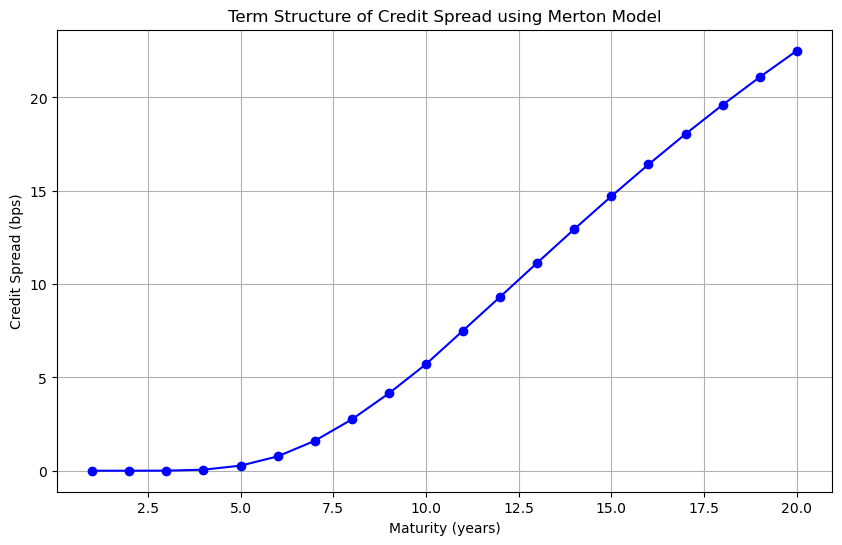

In [10]:
import numpy as np
from scipy.stats import norm
import pandas as pd

# Input Data
# Asset value and volatility on 2024-12-31
v = V_2024
volatility = sigma_V_2024 * np.sqrt(252)
rf = df.Yield / 100
debt = df["Default Point"]

# Select maturities from the debt DataFrame that are >= 1 year
maturities = debt.index[debt.index >= 1]

credit_spreads = []

# Loop over each maturity T to calculate the credit spread
for T in maturities:
    M = debt.loc[T]      # Default boundary (debt level) at this maturity
    r = rf.loc[T]        # Risk-free rate at this maturity
    
    # Calculate d1 and d2 using the Merton model formulas
    d1 = (np.log(v / M) + (r + 0.5 * volatility**2) * T) / (volatility * np.sqrt(T))
    d2 = d1 - volatility * np.sqrt(T)
    
     # Calculate D according to the Merton model
    D = M * np.exp(-r * T) * norm.cdf(d2) + v * norm.cdf(-d1)
    
    # Calculate the credit spread (converted to basis points)
    spread = (-1 / T * np.log(D / M) - r) * 10000
    
    credit_spreads.append(spread)

# Convert the calculated results into a Series with maturities as the index
credit_spread_series = pd.Series(credit_spreads, index=maturities, name="Credit Spread")

# Print the resulting table
print("=== Term Structure of Credit Spread ===")
print(credit_spread_series)

# Plot the term structure of credit spreads
plt.figure(figsize=(10, 6))
plt.plot(credit_spread_series.index, credit_spread_series, marker='o', linestyle='-', color='b')
plt.xlabel("Maturity (years)")
plt.ylabel("Credit Spread (bps)")
plt.title("Term Structure of Credit Spread using Merton Model")
plt.grid(True)
plt.show()

In [11]:
db.close()

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from conda.instructions import PRINT

# NSS parameters from St-Louis Fed
beta0 = 3.385571197
beta1 = 0.938107702
beta2 = -7.40E-05
beta3 = 4.296030822
tau1 = 1.227066261
tau2 = 18.49221165

# Define NSS curve function
def nss_curve(t, beta0, beta1, beta2, beta3, tau1, tau2):
    term1 = beta0
    term2 = beta1 * ((1 - np.exp(-t / tau1)) / (t / tau1))
    term3 = beta2 * (((1 - np.exp(-t / tau1)) / (t / tau1)) - np.exp(-t / tau1))
    term4 = beta3 * (((1 - np.exp(-t / tau2)) / (t / tau2)) - np.exp(-t / tau2))
    return term1 + term2 + term3 + term4

# Observed AA yields
maturities = np.array([0.5, 1, 2, 3, 4, 5, 7, 10, 12, 15, 20, 30])
aa_yields = np.array([4.50, 4.53, 4.59, 4.66, 4.73, 4.81, 5.01, 5.28, 5.42, 5.55, 5.67, 5.77])

# Get treasury yields
risk_free_yields = nss_curve(maturities, beta0, beta1, beta2, beta3, tau1, tau2)

# Get credit spread
credit_spreads = aa_yields - risk_free_yields

# Store results
df_results = pd.DataFrame({
    'Maturity (Years)': maturities,
    'Risk-Free Yield (%)': risk_free_yields.round(2),
    'AA Yield (%)': aa_yields,
    'Credit Spread (bps)': credit_spreads.round(4) * 100  # Convert to basis points
})

df_results

,Maturity (Years),Risk-Free Yield (%),AA Yield (%),Credit Spread (bps)
0,0.5,4.21,4.50,28.69
1,1.0,4.14,4.53,39.08
2,2.0,4.06,4.59,52.54
3,3.0,4.05,4.66,61.10
4,4.0,4.07,4.73,66.50
5,5.0,4.10,4.81,71.21
6,7.0,4.18,5.01,82.62
7,10.0,4.32,5.28,96.26
8,12.0,4.40,5.42,102.32
9,15.0,4.50,5.55,105.38


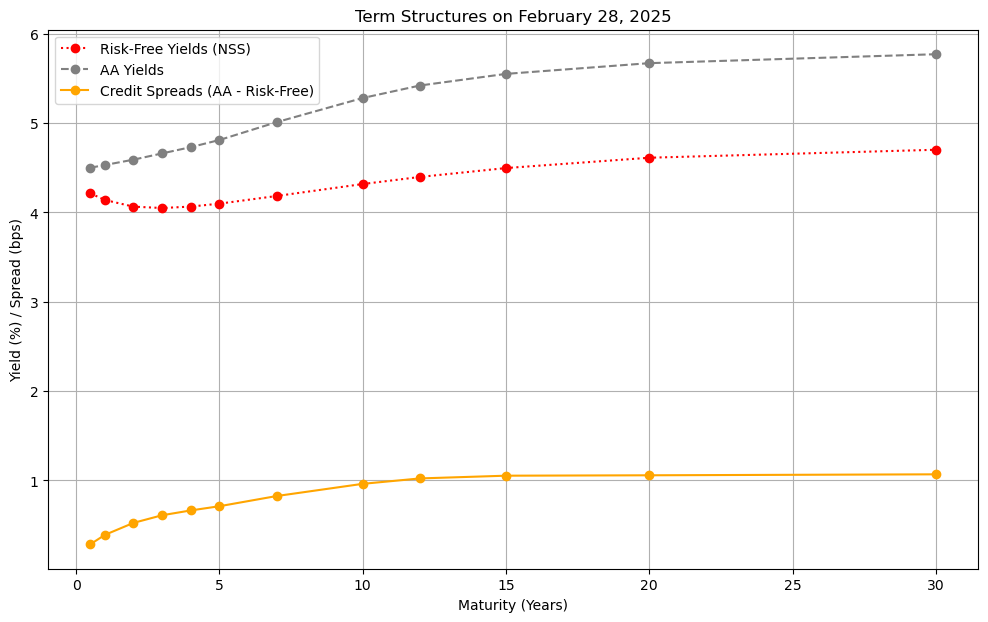

In [2]:
# Plot results
plt.figure(figsize=(12, 7))
plt.plot(maturities, risk_free_yields, label='Risk-Free Yields (NSS)', marker='o', color='r', linestyle=':')
plt.plot(maturities, aa_yields, label='AA Yields', marker='o', color='grey', linestyle='--')
plt.plot(maturities, credit_spreads, label='Credit Spreads (AA - Risk-Free)', marker='o', color='orange', linestyle='-')
plt.xlabel('Maturity (Years)')
plt.ylabel('Yield (%) / Spread (bps)')
plt.title('Term Structures on February 28, 2025')
plt.legend()
plt.grid(True)
plt.show()

    Maturity (Years)  Risk-Free Yield (%)  AA Yield (%)  Credit Spread (bps)
0                0.5               4.2131          4.50                28.69
1                1.0               4.1392          4.53                39.08
2                2.0               4.0646          4.59                52.54
3                3.0               4.0490          4.66                61.10
4                4.0               4.0650          4.73                66.50
5                5.0               4.0979          4.81                71.21
6                7.0               4.1838          5.01                82.62
7               10.0               4.3174          5.28                96.26
8               12.0               4.3968          5.42               102.32
9               15.0               4.4962          5.55               105.38
10              20.0               4.6117          5.67               105.83
11              30.0               4.7010          5.77               106.90

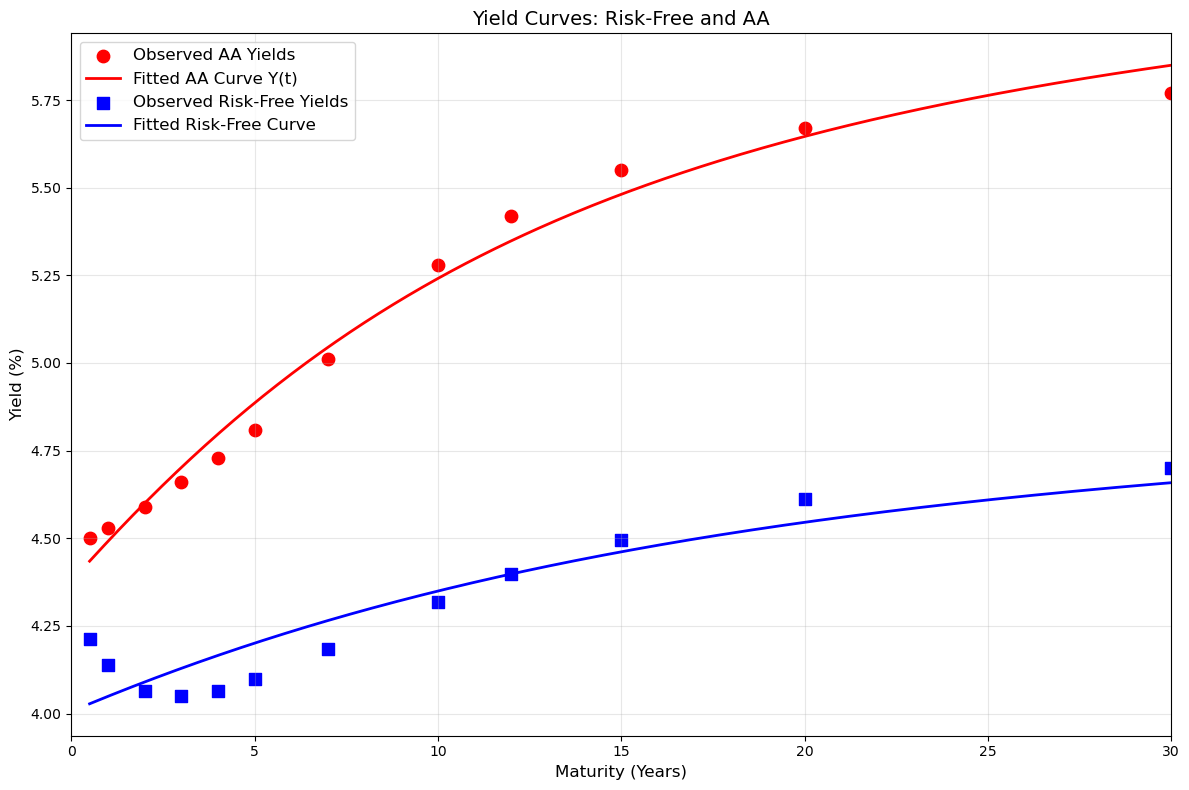


Fit Results:
    Maturity  Observed Risk-Free  Fitted Risk-Free  RF Error  Observed AA  \
0        0.5              4.2131            4.0278   -0.1853         4.50   
1        1.0              4.1392            4.0490   -0.0902         4.53   
2        2.0              4.0646            4.0899    0.0254         4.59   
3        3.0              4.0490            4.1288    0.0799         4.66   
4        4.0              4.0650            4.1658    0.1007         4.73   
5        5.0              4.0979            4.2007    0.1029         4.81   
6        7.0              4.1838            4.2652    0.0815         5.01   
7       10.0              4.3174            4.3494    0.0320         5.28   
8       12.0              4.3968            4.3980    0.0012         5.42   
9       15.0              4.4962            4.4612   -0.0350         5.55   
10      20.0              4.6117            4.5454   -0.0663         5.67   
11      30.0              4.7010            4.6584   -0.0426  

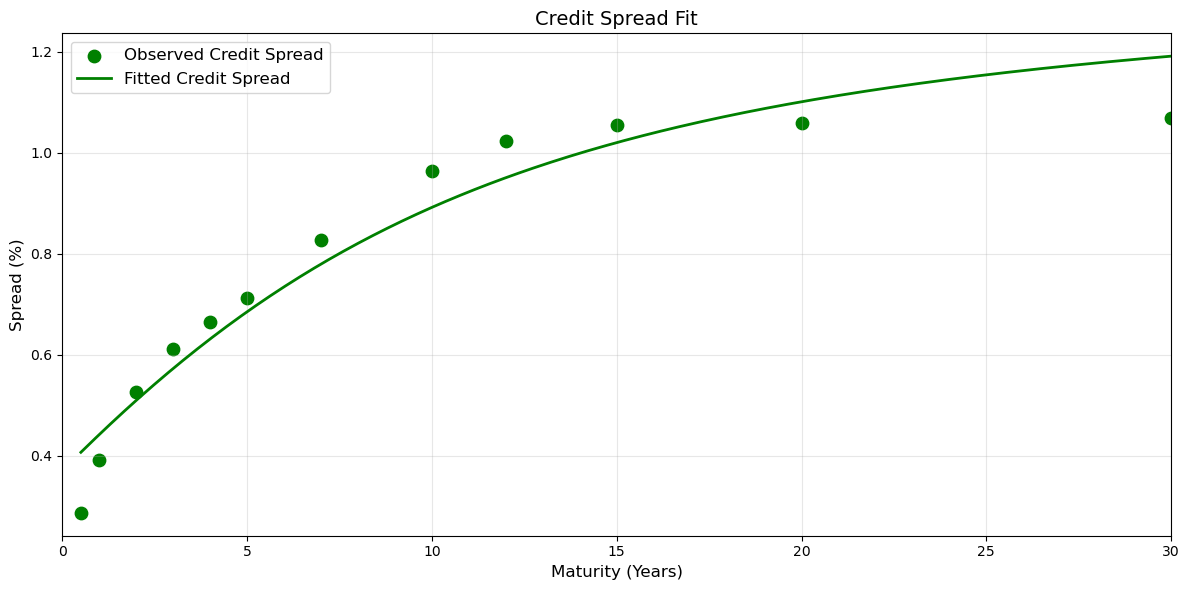

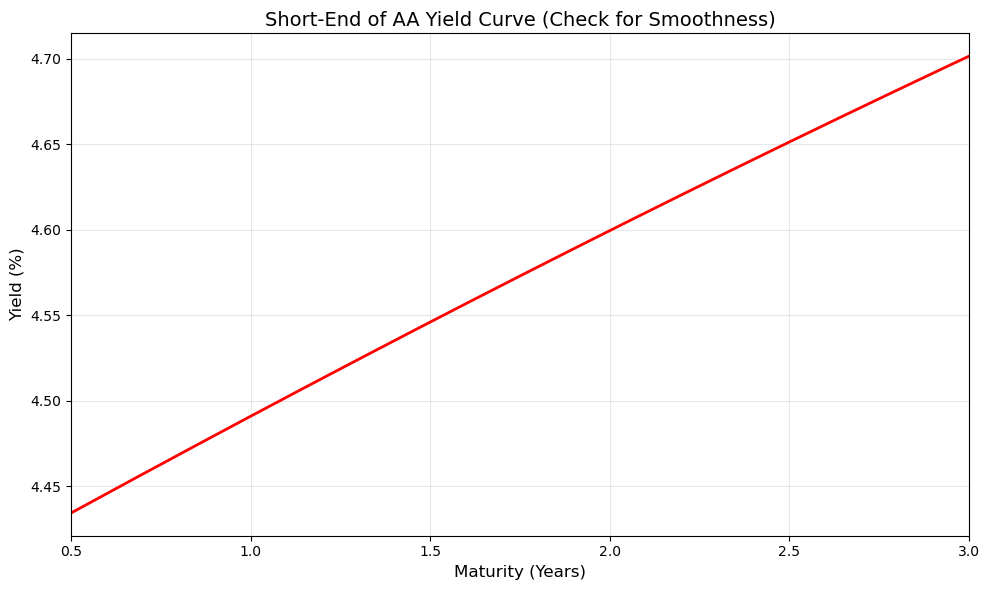


Calibrated Duffee (1999) Model Parameters:
-----------------------------------------
Risk-Free Process:
r0 = 0.002000
kappa_r = 0.050000
theta_r = 0.021625
sigma_r = 0.069258

Credit Spread Process:
s0 = 0.001000
kappa_s = 0.050000
theta_s = 0.031589
sigma_s = 0.145011

Default Intensity Parameters:
alpha = 0.017910
beta = -0.000678


In [141]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize, differential_evolution

# NSS parameters from St-Louis Fed
beta0 = 3.385571197
beta1 = 0.938107702
beta2 = -7.40E-05
beta3 = 4.296030822
tau1 = 1.227066261
tau2 = 18.49221165

# Define NSS curve function
def nss_curve(t, beta0, beta1, beta2, beta3, tau1, tau2):
    term1 = beta0
    term2 = beta1 * ((1 - np.exp(-t / tau1)) / (t / tau1))
    term3 = beta2 * (((1 - np.exp(-t / tau1)) / (t / tau1)) - np.exp(-t / tau1))
    term4 = beta3 * (((1 - np.exp(-t / tau2)) / (t / tau2)) - np.exp(-t / tau2))
    return term1 + term2 + term3 + term4

# Observed AA yields
maturities = np.array([0.5, 1, 2, 3, 4, 5, 7, 10, 12, 15, 20, 30])
aa_yields = np.array([4.50, 4.53, 4.59, 4.66, 4.73, 4.81, 5.01, 5.28, 5.42, 5.55, 5.67, 5.77])

# Get treasury yields
risk_free_yields = nss_curve(maturities, beta0, beta1, beta2, beta3, tau1, tau2)

# Display the data
df_results = pd.DataFrame({
    'Maturity (Years)': maturities,
    'Risk-Free Yield (%)': risk_free_yields.round(4),
    'AA Yield (%)': aa_yields,
    'Credit Spread (bps)': (aa_yields - risk_free_yields).round(4) * 100  # Convert to basis points
})
print(df_results)

# Step 1: Define functions for the risk-free rate model

def A_r(tau, kappa_r, theta_r, sigma_r):
    """Compute the A_r(tau) function for the risk-free rate model."""
    gamma_r = np.sqrt(kappa_r**2 + 2*sigma_r**2)
    term1 = (2 * kappa_r * theta_r) / (sigma_r**2)
    term2 = np.log(2 * gamma_r * np.exp((kappa_r + gamma_r) * tau / 2) / 
                   ((kappa_r + gamma_r) * (np.exp(gamma_r * tau) - 1) + 2 * gamma_r))
    return term1 * (term2 - (kappa_r + gamma_r) * tau / 2)

def B_r(tau, kappa_r, sigma_r):
    """Compute the B_r(tau) function for the risk-free rate model."""
    gamma_r = np.sqrt(kappa_r**2 + 2*sigma_r**2)
    num = 2 * (np.exp(gamma_r * tau) - 1)
    denom = (kappa_r + gamma_r) * (np.exp(gamma_r * tau) - 1) + 2 * gamma_r
    return -2 * num / denom

def risk_free_yield(tau, r0, kappa_r, theta_r, sigma_r):
    """Compute the theoretical zero-coupon yield for the risk-free rate model."""
    a_r = A_r(tau, kappa_r, theta_r, sigma_r)
    b_r = B_r(tau, kappa_r, sigma_r)
    return -(a_r + b_r * r0) / tau

def risk_free_objective(params, maturities, observed_yields):
    """Objective function for risk-free rate calibration."""
    r0, kappa_r, theta_r, sigma_r = params
    if r0 <= 0 or kappa_r <= 0 or theta_r <= 0 or sigma_r <= 0:
        return 1e10  # Penalty for invalid parameters
    
    model_yields = np.array([risk_free_yield(tau, r0, kappa_r, theta_r, sigma_r) for tau in maturities])
    return np.sum((model_yields - observed_yields)**2)

# Step 2: Define functions for the defaultable bond model

def A_s(tau, kappa_s, theta_s, sigma_s):
    """Compute the A_s(tau) function for the spread process."""
    gamma_s = np.sqrt(kappa_s**2 + 2*sigma_s**2)
    term1 = (2 * kappa_s * theta_s) / (sigma_s**2)
    term2 = np.log(2 * gamma_s * np.exp((kappa_s + gamma_s) * tau / 2) / 
                   ((kappa_s + gamma_s) * (np.exp(gamma_s * tau) - 1) + 2 * gamma_s))
    return term1 * (term2 - (kappa_s + gamma_s) * tau / 2)

def B_s(tau, kappa_s, sigma_s):
    """Compute the B_s(tau) function for the spread process."""
    gamma_s = np.sqrt(kappa_s**2 + 2*sigma_s**2)
    num = 2 * (np.exp(gamma_s * tau) - 1)
    denom = (kappa_s + gamma_s) * (np.exp(gamma_s * tau) - 1) + 2 * gamma_s
    return -2 * num / denom

def defaultable_yield(tau, r0, kappa_r, theta_r, sigma_r, s0, kappa_s, theta_s, sigma_s, alpha, beta):
    """Compute the theoretical defaultable zero-coupon yield."""
    # Risk-free component
    a_r = A_r(tau, kappa_r, theta_r, sigma_r)
    b_r = B_r(tau, kappa_r, sigma_r)
    
    # Spread component
    a_s = A_s(tau, kappa_s, theta_s, sigma_s)
    b_s = B_s(tau, kappa_s, sigma_s)
    
    # Alpha and beta effect
    C = alpha * tau
    D = beta * (1 - np.exp(-kappa_r * tau)) / (kappa_r * tau)
    
    # Total yield
    return -(a_r + b_r * r0 + a_s + b_s * s0 + C + D * r0) / tau

# Modified defaultable objective function with smoothness constraint
def defaultable_objective_smooth(params, maturities, observed_yields, r0, kappa_r, theta_r, sigma_r, smoothness_weight=1000.0):
    """Objective function for defaultable yield calibration with smoothness constraint."""
    s0, kappa_s, theta_s, sigma_s, alpha, beta = params
    if s0 <= 0 or kappa_s <= 0 or theta_s <= 0 or sigma_s <= 0:
        return 1e10  # Penalty for invalid parameters
    
    # Calculate model yields at observed maturities
    model_yields = np.array([defaultable_yield(tau, r0, kappa_r, theta_r, sigma_r, 
                                              s0, kappa_s, theta_s, sigma_s, alpha, beta) 
                            for tau in maturities])
    
    # Calculate data fit component
    data_fit = np.sum((model_yields - observed_yields)**2)
    
    # Add smoothness constraint (especially important for short maturities)
    # Create a fine grid of maturities for measuring smoothness
    fine_maturities = np.linspace(0.1, 3.0, 100)  # Focus on short end
    fine_yields = np.array([defaultable_yield(tau, r0, kappa_r, theta_r, sigma_r, 
                                            s0, kappa_s, theta_s, sigma_s, alpha, beta) 
                          for tau in fine_maturities])
    
    # Calculate first differences to measure smoothness
    yield_diffs = np.diff(fine_yields)
    
    # Penalize large changes in the slope (second differences)
    smoothness_penalty = np.sum(np.diff(yield_diffs)**2)
    
    # Combine data fit and smoothness penalty
    return data_fit + smoothness_weight * smoothness_penalty

# Multi-start optimization function
def multi_start_optimization(objective_func, bounds, args, n_trials=5, method='L-BFGS-B'):
    """Run optimization from multiple starting points to avoid local minima."""
    best_result = None
    best_value = float('inf')
    
    for i in range(n_trials):
        # Generate random starting point within bounds
        initial_guess = np.array([np.random.uniform(low, high) for low, high in bounds])
        
        # Run optimization
        result = minimize(
            objective_func,
            initial_guess,
            args=args,
            bounds=bounds,
            method=method
        )
        
        # Keep track of best result
        if result.fun < best_value:
            best_value = result.fun
            best_result = result
            
    return best_result

# Global optimization using differential evolution
def global_optimization(objective_func, bounds, args):
    """Use differential evolution to find global minimum."""
    result = differential_evolution(
        objective_func,
        bounds,
        args=args,
        popsize=20,
        mutation=(0.5, 1.0),
        recombination=0.7,
        tol=1e-6,
        maxiter=1000
    )
    return result

# Step 1: Calibrate risk-free parameters with improved search
print("\nCalibrating risk-free parameters...")

# Define bounds for risk-free parameters: r0, kappa_r, theta_r, sigma_r
bounds_rf = [(0.002, 0.08), (0.05, 5.0), (0.01, 0.2), (0.01, 0.5)]

# Try different neighborhoods for the initial guesses
initial_guesses_rf = [
    [0.01, 0.15, 0.039, 0.077],   # Original guess
    [0.02, 0.5, 0.05, 0.1],       # Higher values
    [0.005, 0.1, 0.02, 0.05],     # Lower values
    [0.01, 1.0, 0.1, 0.2],        # Mixed values
    [0.015, 0.25, 0.075, 0.15]    # Medium values
]

print("Using global optimization (differential evolution) for risk-free curve...")
result_rf_global = global_optimization(
    risk_free_objective, 
    bounds_rf,
    args=(maturities, risk_free_yields/100)  # Convert from percent to decimal
)

r0, kappa_r, theta_r, sigma_r = result_rf_global.x
print(f"Global optimization results:")
print(f"r0 = {r0:.6f}")
print(f"kappa_r = {kappa_r:.6f}")
print(f"theta_r = {theta_r:.6f}")
print(f"sigma_r = {sigma_r:.6f}")
print(f"Objective value: {result_rf_global.fun:.8f}")

# Try local optimization from multiple starting points
print("\nUsing multi-start local optimization for risk-free curve...")
best_result_rf = None
best_objective_rf = float('inf')

for i, guess in enumerate(initial_guesses_rf):
    print(f"Trying initial guess set {i+1}...")
    result = minimize(
        risk_free_objective, 
        guess,
        args=(maturities, risk_free_yields/100),
        bounds=bounds_rf,
        method='L-BFGS-B'
    )
    
    print(f"  Objective value: {result.fun:.8f}")
    if result.fun < best_objective_rf:
        best_objective_rf = result.fun
        best_result_rf = result
        print(f"  New best result found!")

# Compare results and choose the best
if best_result_rf is not None and best_result_rf.fun < result_rf_global.fun:
    print("\nLocal optimization produced better results")
    r0, kappa_r, theta_r, sigma_r = best_result_rf.x
else:
    print("\nGlobal optimization produced better results")
    r0, kappa_r, theta_r, sigma_r = result_rf_global.x

print(f"Final optimal risk-free parameters:")
print(f"r0 = {r0:.6f}")
print(f"kappa_r = {kappa_r:.6f}")
print(f"theta_r = {theta_r:.6f}")
print(f"sigma_r = {sigma_r:.6f}")

# Evaluate the fit of the risk-free model 
fitted_rf_yields = np.array([risk_free_yield(tau, r0, kappa_r, theta_r, sigma_r) for tau in maturities]) * 100  # Convert to percent
rf_rmse = np.sqrt(np.mean((fitted_rf_yields - risk_free_yields)**2))
print(f"Risk-free RMSE: {rf_rmse:.6f}%")

# Step 2: Calibrate defaultable parameters with improved search and smoothness constraint
print("\nCalibrating defaultable parameters with smoothness constraint...") 

# Define bounds for defaultable parameters: s0, kappa_s, theta_s, sigma_s, alpha, beta
bounds_def = [(0.001, 0.1), (0.05, 5.0), (0.001, 0.1), (0.01, 0.5), (-0.1, 0.1), (-1.0, 1.0)]

# Try different neighborhoods for the initial guesses
initial_guesses_def = [
    [0.025, 0.33, 0.06, 0.19, 0.006, 0.5],    # Original guess
    [0.05, 1.0, 0.05, 0.2, 0.01, 0.3],        # Higher values
    [0.01, 0.2, 0.02, 0.1, -0.01, 0.1],       # Lower values
    [0.03, 2.0, 0.07, 0.3, 0.05, -0.2],       # Mixed values
    [0.02, 0.5, 0.04, 0.15, -0.02, 0.4]       # Medium values
]

# Define the smoothness weight
smoothness_weight = 1000.0

print("Using global optimization (differential evolution) for defaultable curve with smoothness...")
result_def_global = global_optimization(
    defaultable_objective_smooth, 
    bounds_def,
    args=(maturities, aa_yields/100, r0, kappa_r, theta_r, sigma_r, smoothness_weight)
)

s0, kappa_s, theta_s, sigma_s, alpha, beta = result_def_global.x
print(f"Global optimization results:")
print(f"s0 = {s0:.6f}")
print(f"kappa_s = {kappa_s:.6f}")
print(f"theta_s = {theta_s:.6f}")
print(f"sigma_s = {sigma_s:.6f}")
print(f"alpha = {alpha:.6f}")
print(f"beta = {beta:.6f}")
print(f"Objective value: {result_def_global.fun:.8f}")

# Try local optimization from multiple starting points
print("\nUsing multi-start local optimization for defaultable curve with smoothness...")
best_result_def = None
best_objective_def = float('inf')

for i, guess in enumerate(initial_guesses_def):
    print(f"Trying initial guess set {i+1}...")
    result = minimize(
        defaultable_objective_smooth, 
        guess,
        args=(maturities, aa_yields/100, r0, kappa_r, theta_r, sigma_r, smoothness_weight),
        bounds=bounds_def,
        method='L-BFGS-B'
    )
    
    print(f"  Objective value: {result.fun:.8f}")
    if result.fun < best_objective_def:
        best_objective_def = result.fun
        best_result_def = result
        print(f"  New best result found!")

# Compare results and choose the best
if best_result_def is not None and best_result_def.fun < result_def_global.fun:
    print("\nLocal optimization produced better results")
    s0, kappa_s, theta_s, sigma_s, alpha, beta = best_result_def.x
else:
    print("\nGlobal optimization produced better results")
    s0, kappa_s, theta_s, sigma_s, alpha, beta = result_def_global.x

print(f"Final optimal defaultable parameters:")
print(f"s0 = {s0:.6f}")
print(f"kappa_s = {kappa_s:.6f}")
print(f"theta_s = {theta_s:.6f}")
print(f"sigma_s = {sigma_s:.6f}")
print(f"alpha = {alpha:.6f}")
print(f"beta = {beta:.6f}")

# Evaluate the fit of the defaultable model
fitted_def_yields = np.array([defaultable_yield(tau, r0, kappa_r, theta_r, sigma_r, 
                                             s0, kappa_s, theta_s, sigma_s, alpha, beta) 
                           for tau in maturities]) * 100  # Convert to percent
def_rmse = np.sqrt(np.mean((fitted_def_yields - aa_yields)**2))
print(f"Defaultable RMSE: {def_rmse:.6f}%")

# Create a continuous yield curve for plotting
fine_maturities = np.linspace(0.5, 30, 300)  # Start from 0.5 years
fitted_rf_curve = np.array([risk_free_yield(tau, r0, kappa_r, theta_r, sigma_r) for tau in fine_maturities]) * 100
fitted_def_curve = np.array([defaultable_yield(tau, r0, kappa_r, theta_r, sigma_r, 
                                             s0, kappa_s, theta_s, sigma_s, alpha, beta) 
                           for tau in fine_maturities]) * 100

# Create a very fine grid for checking smoothness
very_fine_maturities = np.linspace(0.5, 3, 500)  # Focus on short end where cusp might occur
very_fine_def_curve = np.array([defaultable_yield(tau, r0, kappa_r, theta_r, sigma_r, 
                                                s0, kappa_s, theta_s, sigma_s, alpha, beta) 
                              for tau in very_fine_maturities]) * 100

# Calculate derivatives to check for cusps
def_curve_diffs = np.diff(very_fine_def_curve) / np.diff(very_fine_maturities)
print(f"\nMax derivative change: {np.max(np.abs(np.diff(def_curve_diffs))):.6f}")

# Create a single plot with both yield curves
plt.figure(figsize=(12, 8))

# Plot both curves on the same graph
plt.scatter(maturities, aa_yields, color='red', marker='o', s=80, label='Observed AA Yields')
plt.plot(fine_maturities, fitted_def_curve, 'r-', linewidth=2, label='Fitted AA Curve Y(t)')
plt.scatter(maturities, risk_free_yields, color='blue', marker='s', s=80, label='Observed Risk-Free Yields')
plt.plot(fine_maturities, fitted_rf_curve, 'b-', linewidth=2, label='Fitted Risk-Free Curve')

plt.xlabel('Maturity (Years)', fontsize=12)
plt.ylabel('Yield (%)', fontsize=12)
plt.title('Yield Curves: Risk-Free and AA', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)
plt.xlim(0, 30)  # Set x-axis limits
plt.tight_layout()
plt.show()

# Create a table of results
results_df = pd.DataFrame({
    'Maturity': maturities,
    'Observed Risk-Free': risk_free_yields,
    'Fitted Risk-Free': fitted_rf_yields,
    'RF Error': fitted_rf_yields - risk_free_yields,
    'Observed AA': aa_yields,
    'Fitted AA': fitted_def_yields,
    'AA Error': fitted_def_yields - aa_yields
})

print("\nFit Results:")
print(results_df.round(4))

# Calculate root mean squared errors
rf_rmse = np.sqrt(np.mean((fitted_rf_yields - risk_free_yields)**2))
def_rmse = np.sqrt(np.mean((fitted_def_yields - aa_yields)**2))
print(f"\nRisk-Free RMSE: {rf_rmse:.6f}%")
print(f"AA RMSE: {def_rmse:.6f}%")

# Plot the credit spread
plt.figure(figsize=(12, 6))
observed_spread = aa_yields - risk_free_yields
fitted_spread = fitted_def_yields - fitted_rf_yields
continuous_spread = fitted_def_curve - fitted_rf_curve

plt.scatter(maturities, observed_spread, color='green', marker='o', s=80, label='Observed Credit Spread')
plt.plot(fine_maturities, continuous_spread, 'g-', linewidth=2, label='Fitted Credit Spread')
plt.xlabel('Maturity (Years)', fontsize=12)
plt.ylabel('Spread (%)', fontsize=12)
plt.title('Credit Spread Fit', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)
plt.xlim(0, 30)  # Set x-axis limits
plt.tight_layout()
plt.show()

# Check the short-end smoothness specifically
plt.figure(figsize=(10, 6))
plt.plot(very_fine_maturities, very_fine_def_curve, 'r-', linewidth=1)
plt.title('Short-End of AA Yield Curve (Check for Smoothness)', fontsize=14)
plt.xlabel('Maturity (Years)', fontsize=12)
plt.ylabel('Yield (%)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xlim(0.5, 3)  # Focus on short end
plt.tight_layout()
plt.show()

# Print final parameters summary
print("\nCalibrated Duffee (1999) Model Parameters:")
print("-----------------------------------------")
print(f"Risk-Free Process:")
print(f"r0 = {r0:.6f}")
print(f"kappa_r = {kappa_r:.6f}")
print(f"theta_r = {theta_r:.6f}")
print(f"sigma_r = {sigma_r:.6f}")
print(f"\nCredit Spread Process:")
print(f"s0 = {s0:.6f}")
print(f"kappa_s = {kappa_s:.6f}")
print(f"theta_s = {theta_s:.6f}")
print(f"sigma_s = {sigma_s:.6f}")
print(f"\nDefault Intensity Parameters:")
print(f"alpha = {alpha:.6f}")
print(f"beta = {beta:.6f}")

In [144]:
# region 

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import newton

# Bond characteristics
face_value = 1_000_000
coupon_rate = 0.04  # 4% annual rate
coupon_freq = 2  # semi-annual payments
maturity = 5.0  # 5 years
coupon_amount = face_value * (coupon_rate / coupon_freq)
num_coupons = int(maturity * coupon_freq)
coupon_times = np.linspace(1/coupon_freq, maturity, num_coupons)

# Finite difference grid parameters
dt = 1/120  
num_time_steps = int(maturity / dt) + 1
time_grid = np.linspace(0, maturity, num_time_steps)

# r and s grid parameters
r_min, r_max = 0.01, 0.08  # 1% to 15%
s_min, s_max = 0.001, 0.02  # 10 bps to 200 bps
nr = 50  # number of points in r direction
ns = 50  # number of points in s direction
dr = (r_max - r_min) / (nr - 1)
ds = (s_max - s_min) / (ns - 1)
r_grid = np.linspace(r_min, r_max, nr)
s_grid = np.linspace(s_min, s_max, ns)

# Create 2D meshgrid
R, S = np.meshgrid(r_grid, s_grid)

# Initialize the bond value matrix (3D: time x r x s)
V = np.zeros((num_time_steps, nr, ns))

# Terminal condition: bond value at maturity is face value
V[-1, :, :] = face_value

# Function to find the closest index for a given time
def find_closest_time_index(t, time_grid):
    return np.argmin(np.abs(time_grid - t))

# Initialize a coupon payment indicator
is_coupon_date = np.zeros(num_time_steps)
for coupon_time in coupon_times:
    idx = find_closest_time_index(coupon_time, time_grid)
    is_coupon_date[idx] = 1

# Calculate default intensity for each point in the grid
def calculate_lambda(r, s):
    return alpha + beta * r + s

# Duffee closed-form functions for A and B
def A_r(tau, kappa_r, theta_r, sigma_r):
    """Compute the A_r(tau) function for the risk-free rate model."""
    gamma_r = np.sqrt(kappa_r**2 + 2*sigma_r**2)
    term1 = (2 * kappa_r * theta_r) / (sigma_r**2)
    term2 = np.log(2 * gamma_r * np.exp((kappa_r + gamma_r) * tau / 2) / 
                   ((kappa_r + gamma_r) * (np.exp(gamma_r * tau) - 1) + 2 * gamma_r))
    return term1 * (term2 - (kappa_r + gamma_r) * tau / 2)

def B_r(tau, kappa_r, sigma_r):
    """Compute the B_r(tau) function for the risk-free rate model."""
    gamma_r = np.sqrt(kappa_r**2 + 2*sigma_r**2)
    num = 2 * (np.exp(gamma_r * tau) - 1)
    denom = (kappa_r + gamma_r) * (np.exp(gamma_r * tau) - 1) + 2 * gamma_r
    return -2 * num / denom

def A_s(tau, kappa_s, theta_s, sigma_s):
    """Compute the A_s(tau) function for the spread process."""
    gamma_s = np.sqrt(kappa_s**2 + 2*sigma_s**2)
    term1 = (2 * kappa_s * theta_s) / (sigma_s**2)
    term2 = np.log(2 * gamma_s * np.exp((kappa_s + gamma_s) * tau / 2) / 
                   ((kappa_s + gamma_s) * (np.exp(gamma_s * tau) - 1) + 2 * gamma_s))
    return term1 * (term2 - (kappa_s + gamma_s) * tau / 2)

def B_s(tau, kappa_s, sigma_s):
    """Compute the B_s(tau) function for the spread process."""
    gamma_s = np.sqrt(kappa_s**2 + 2*sigma_s**2)
    num = 2 * (np.exp(gamma_s * tau) - 1)
    denom = (kappa_s + gamma_s) * (np.exp(gamma_s * tau) - 1) + 2 * gamma_s
    return -2 * num / denom

# Function to calculate the zero-coupon bond price using Duffee model
def zero_coupon_price(t, T, r, s, kappa_r, theta_r, sigma_r, kappa_s, theta_s, sigma_s, alpha, beta):
    tau = T - t
    if tau <= 0:
        return 1.0
    
    # Risk-free component
    a_r = A_r(tau, kappa_r, theta_r, sigma_r)
    b_r = B_r(tau, kappa_r, sigma_r)
    
    # Spread component
    a_s = A_s(tau, kappa_s, theta_s, sigma_s)
    b_s = B_s(tau, kappa_s, sigma_s)
    
    # Alpha and beta effect
    C = alpha * tau
    D = beta * (1 - np.exp(-kappa_r * tau)) / (kappa_r * tau)
    
    # Total discount factor
    return np.exp(a_r + b_r * r + a_s + b_s * s + C + D * r)

# Function to price a straight bond (without call feature) using Duffee closed-form
def price_straight_bond(t, r, s, face_value, coupon_rate, coupon_freq, maturity):
    if t >= maturity:
        return face_value
    
    remaining_time = maturity - t
    num_remaining_coupons = int(np.ceil(remaining_time * coupon_freq))
    coupon_amount = face_value * (coupon_rate / coupon_freq)
    
    # Create coupon times
    next_coupon_time = np.ceil(t * coupon_freq) / coupon_freq
    coupon_times = np.linspace(next_coupon_time, maturity, num_remaining_coupons)
    coupon_times = coupon_times[coupon_times > t]  # Ensure all coupons are in the future
    
    bond_value = 0
    # Add PV of coupon payments
    for coupon_time in coupon_times:
        discount_factor = zero_coupon_price(
            t, coupon_time, r, s, kappa_r, theta_r, sigma_r, kappa_s, theta_s, sigma_s, alpha, beta)
        bond_value += coupon_amount * discount_factor
    
    # Add PV of principal
    discount_factor = zero_coupon_price(
        t, maturity, r, s, kappa_r, theta_r, sigma_r, kappa_s, theta_s, sigma_s, alpha, beta)
    bond_value += face_value * discount_factor
    
    return bond_value

# Explicit finite difference scheme
def explicit_fd_step(V_next, r_grid, s_grid, dr, ds, dt, kappa_r, theta_r, sigma_r, kappa_s, theta_s, sigma_s):
    V_curr = np.zeros_like(V_next)
    
    for i in range(1, nr-1):  # Interior r points
        for j in range(1, ns-1):  # Interior s points
            r = r_grid[i]
            s = s_grid[j]
            
            # Short rate drift and diffusion
            mu_r = kappa_r * (theta_r - r)
            sigma_r_squared = sigma_r**2 * r
            
            # Spread drift and diffusion
            mu_s = kappa_s * (theta_s - s)
            sigma_s_squared = sigma_s**2 * s
            
            # Default intensity
            lambda_rs = calculate_lambda(r, s)
            
            # Finite difference coefficients for r
            a_r = 0.5 * (sigma_r_squared / dr**2 - mu_r / dr)
            b_r = -sigma_r_squared / dr**2
            c_r = 0.5 * (sigma_r_squared / dr**2 + mu_r / dr)
            
            # Finite difference coefficients for s
            a_s = 0.5 * (sigma_s_squared / ds**2 - mu_s / ds)
            b_s = -sigma_s_squared / ds**2
            c_s = 0.5 * (sigma_s_squared / ds**2 + mu_s / ds)
            
            # Explicit update
            V_curr[i, j] = (1 - dt * (r + lambda_rs)) * V_next[i, j] + \
                           dt * (a_r * V_next[i-1, j] + b_r * V_next[i, j] + c_r * V_next[i+1, j]) + \
                           dt * (a_s * V_next[i, j-1] + b_s * V_next[i, j] + c_s * V_next[i, j+1])
    
    # Boundary conditions using coupon bond prices
    for j in range(ns):
        s = s_grid[j]
        # Left boundary (r = r_min)
        r = r_min
        V_curr[0, j] = price_straight_bond(time_grid[t_idx], r, s, face_value, coupon_rate, coupon_freq, maturity)
        
        # Right boundary (r = r_max)
        r = r_max
        V_curr[-1, j] = price_straight_bond(time_grid[t_idx], r, s, face_value, coupon_rate, coupon_freq, maturity)
    
    for i in range(nr):
        r = r_grid[i]
        # Bottom boundary (s = s_min)
        s = s_min
        V_curr[i, 0] = price_straight_bond(time_grid[t_idx], r, s, face_value, coupon_rate, coupon_freq, maturity)
        
        # Top boundary (s = s_max)
        s = s_max
        V_curr[i, -1] = price_straight_bond(time_grid[t_idx], r, s, face_value, coupon_rate, coupon_freq, maturity)
    
    return V_curr

# Calculate yield to maturity for a given bond price
def calculate_ytm(price, face_value, coupon_rate, coupon_freq, maturity):
    # Define function whose root gives the YTM
    def npv_function(y):
        pv = 0
        for t in range(1, int(maturity * coupon_freq) + 1):
            pv += (coupon_rate * face_value / coupon_freq) / ((1 + y/coupon_freq) ** t)
        pv += face_value / ((1 + y/coupon_freq) ** (maturity * coupon_freq))
        return pv - price
    
    # Use Newton's method to find the root
    try:
        ytm = newton(npv_function, 0.05)  # Start with a 5% initial guess
        return ytm
    except:
        # Fall back to a bisection search if Newton fails
        low, high = 0.0001, 1.0
        while high - low > 1e-6:
            mid = (low + high) / 2
            if npv_function(mid) * npv_function(low) < 0:
                high = mid
            else:
                low = mid
        return (low + high) / 2

# Backward time-stepping with call option
t_idx = 0  # Track current time index globally for boundary conditions
for t in range(num_time_steps-2, -1, -1):
    t_idx = t  # Update global index
    # Add coupon payment if it's a coupon date
    if is_coupon_date[t]:
        V[t] = V[t+1] + coupon_amount
    else:
        V[t] = V[t+1]
    
    # Apply explicit finite difference step
    V[t] = explicit_fd_step(V[t], r_grid, s_grid, dr, ds, dt, kappa_r, theta_r, sigma_r, kappa_s, theta_s, sigma_s)
    
    # Apply callable feature - compare with face value (callable at par)
    V[t] = np.minimum(V[t], face_value)

# Find the initial bond value (at r0, s0)
r0_idx = np.argmin(np.abs(r_grid - r0))
s0_idx = np.argmin(np.abs(s_grid - s0))
callable_bond_value = V[0, r0_idx, s0_idx]

# Calculate the value of the bond without the call option
straight_bond_value = price_straight_bond(0, r0, s0, face_value, coupon_rate, coupon_freq, maturity)

# Calculate the value of the call option
call_option_value = straight_bond_value - callable_bond_value

# Calculate yields
callable_bond_ytm = calculate_ytm(callable_bond_value, face_value, coupon_rate, coupon_freq, maturity)
straight_bond_ytm = calculate_ytm(straight_bond_value, face_value, coupon_rate, coupon_freq, maturity)

# Print results
print("\n" + "="*50)
print("AA CORPORATE BOND VALUATION RESULTS")
print("="*50)
print(f"Bond Nominal: ${face_value:,.2f}")
print(f"Maturity: {maturity} years")
print(f"Coupon Rate: {coupon_rate*100:.2f}% paid semi-annually")
print(f"Current Risk-Free Rate (r0): {r0*100:.4f}%")
print(f"Current Credit Spread (s0): {s0*100:.4f}%")
print(f"Default Intensity: {calculate_lambda(r0, s0)*100:.4f}%")
print("\n" + "-"*50)

print(f"Straight Bond Value: ${straight_bond_value:,.2f}")
print(f"Straight Bond Yield: {straight_bond_ytm*100:.4f}%")

print("\n" + "-"*50)
print(f"Callable Bond Value: ${callable_bond_value:,.2f}")
print(f"Callable Bond Yield: {callable_bond_ytm*100:.4f}%")

print("\n" + "-"*50)
print(f"Call Option Value: ${call_option_value:,.2f}")
print(f"Yield Spread due to Call: {(callable_bond_ytm - straight_bond_ytm)*100:.4f}%")
print("="*50)

# endregion 


AA CORPORATE BOND VALUATION RESULTS
Bond Nominal: $1,000,000.00
Maturity: 5.0 years
Coupon Rate: 4.00% paid semi-annually
Current Risk-Free Rate (r0): 0.2000%
Current Credit Spread (s0): 0.1000%
Default Intensity: 1.8908%

--------------------------------------------------
Straight Bond Value: $941,421.17
Straight Bond Yield: 5.3508%

--------------------------------------------------
Callable Bond Value: $882,764.80
Callable Bond Yield: 6.8055%

--------------------------------------------------
Call Option Value: $58,656.37
Yield Spread due to Call: 1.4547%
